In [1]:
import sys
sys.path.append('../..')
import scripts.radossim as sim
import matplotlib.pyplot as plt
import numpy as np
print('done.')

done.


In [2]:
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

In [3]:
def plot(x, y, x_label=None, y_label=None, title=None, color='green'):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.grid(True)
    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label)
    ax.plot(x, y, color=color, label=title)
    if title:
        ax.legend()
    plt.show()

def printResults(avgThroughput, avgOsdQueueLen, info, timeLog=None, batchSizeLog=None):
    data = info['requests']
    print(data[0])
    batchSizeInfo = info['kv_batch_sizes']
    print()
    print('Results:')
    print(f'\t avg Throughput: {avgThroughput} MB/s')
    print(f'\t avg Osd Queue Size: {avgOsdQueueLen}')
    kvQueueLats = [aioSubmit - arrivalKV for (((((_, _, _), _), arrivalKV), aioSubmit, aioDone), kvQDispatch, kvDone) in data]
    kvLats = [kvDone - arrivalKV for (((((_, _, _), _), arrivalKV), aioSubmit, aioDone), kvQDispatch, kvDone) in data]
    kvQueueLats = [lat for lat in kvQueueLats if lat < 100_000]
    avgBlueStoreLat = sum(kvLats) / len(kvLats)
    mvAvg = moving_avg(kvQueueLats, 1000)
    avgKVQueueLat = sum(mvAvg) / len(mvAvg)
    print(f'\t avg BlueStore Latency: {avgBlueStoreLat / 1_000} ms')
    print(f'\t avg BlueStore Queue Latency: {avgKVQueueLat / 1_000} ms')
    print()
    time = [arrivalKV for (((((_, _, _), _), arrivalKV), _, _), _, _) in data]
    if batchSizeLog:
        plot(timeLog, batchSizeLog, x_label='Time', y_label='Batch Size', color='green', title='CoDel Batch Size')
    plot(time[0:len(mvAvg)], mvAvg, x_label='Time', y_label='Queuing Latency', color='red', title='Queuing Latency')
    plot(time, kvLats, x_label='Time', y_label='Latency', color='blue', title='Latency')
    plot(batchSizeInfo['time'], batchSizeInfo['size'], x_label='Time', y_label='Batch Size', color='black', title='KV Batch Size')

def printTitle(title):
    print('************************************************')
    print(title)
    print('************************************************')
    print()
    
def printSeparator():
    print()
    print('=========================================================')
    print()

In [4]:
def runSimulations(targetLatSettings = [100],
                   intervalSettings = [1000],
                   batchDownSizeSettings = [2],
                   batchUpSizeSettings = [1],
                   simulationTimeSettings = [60 * 1_000_000],
                   modelPath = '../latModel/latency_model_4K.yaml',
                   adaptiveSettings=[False],
                   smartDownSizingSamplesSettings=[1],
                   limitPortion=1.5,
                   without=False
                  ):
    if not without:
        printTitle('Simulation without CoDel')

        print('Simulation running...')
        avgThroughput, avgOsdQueueLen, data, _, log = sim.runSimulation(
            modelPath,
            0,
            0,
            simulationTimeSettings[0],
            useCoDel=False,
            downSize=2,
            upSize=1,
            adaptive=adaptiveSettings[0],
            smartDownSizingSamples=smartDownSizingSamplesSettings[0]
        )
        avgThroughput = avgThroughput / 1024
        avgThroughput = avgThroughput / 1024
        print('Simulation done')
        print(log)
        printResults(avgThroughput, avgOsdQueueLen, data)


    printTitle('Simulation with CoDel')

    i = 1
    for time in simulationTimeSettings:
        for targetLat in targetLatSettings:
            for interval in intervalSettings:
                for downSize in batchDownSizeSettings:
                    for upSize in batchUpSizeSettings:
                        for smartDownSizingSamples in smartDownSizingSamplesSettings:
                            for adaptive in adaptiveSettings:
                                print(f'Simulation profile #{i}:')
                                print(f'\t time: {time}')
                                print(f'\t targetLat: {targetLat}')
                                print(f'\t interval: {interval}')
                                print(f'\t downSize: {downSize}')
                                print(f'\t upSize: {upSize}')
                                print(f'\t smartDownSizingSamples: {smartDownSizingSamples}')
                                print()
                                print('\t Simulation running...')
                                avgThroughput, avgOsdQueueLen, data, timeLog, batchSizeLog = sim.runSimulation(
                                    modelPath,
                                    targetLat,
                                    interval,
                                    time,
                                    useCoDel=True,
                                    downSize=downSize,
                                    upSize=upSize,
                                    adaptive=adaptive,
                                    smartDownSizingSamples=smartDownSizingSamples
                                )
                                avgThroughput = avgThroughput / 1024
                                avgThroughput = avgThroughput / 1024
                                print('\t Simulation done')
                                printResults(avgThroughput, avgOsdQueueLen, data, timeLog, batchSizeLog)
                                printSeparator()
                                i += 1


************************************************
Simulation without CoDel
************************************************

Simulation running...
L0 Compaction
L0 Compaction
L0 Compaction
L0 Compaction
L1 Compaction
L > 1 Compaction
L0 Compaction
698991.0
Simulation done
[13]
(((((1, 4096, 5), False), 5), 5, 248.67460739555375), 248.67460739555375, 304.33392349677644)

Results:
	 avg Throughput: 45.5072265625 MB/s
	 avg Osd Queue Size: 7.97812706317251
	 avg BlueStore Latency: 1.8902783314376308 ms
	 avg BlueStore Queue Latency: 0.8112029404874502 ms



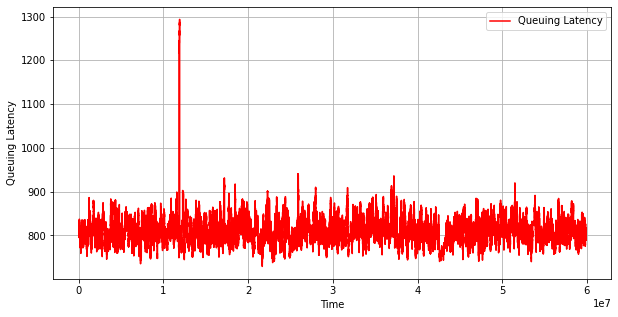

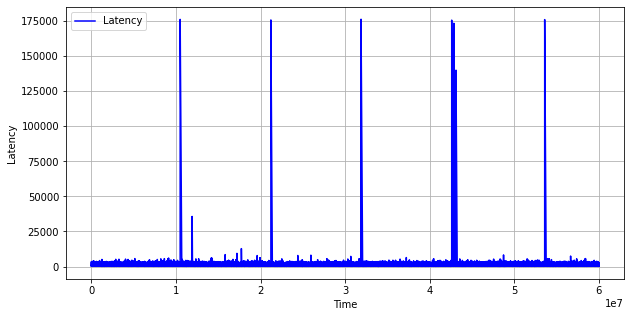

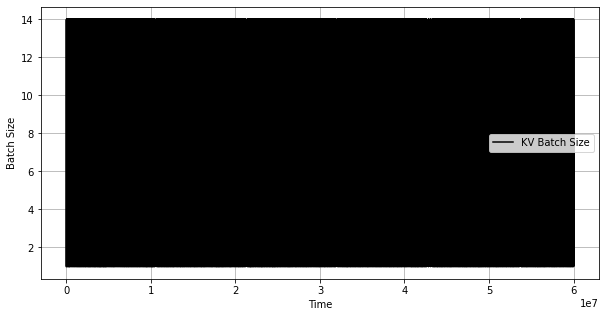

************************************************
Simulation with CoDel
************************************************

Simulation profile #1:
	 time: 60000000
	 targetLat: 500
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 smartDownSizingSamples: 1

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
L0 Compaction
L1 Compaction
L > 1 Compaction


KeyboardInterrupt: 

In [5]:
targetLatSettings = [500]
intervalSettings = [1000]


runSimulations(targetLatSettings,
                   intervalSettings,
               [2, 2.5, 3]
                  )

runSimulations(targetLatSettings,
                   intervalSettings,
               adaptive=[True],
               smartDownSizingSamplesSettings=[1],
               without=True
                  )


In [ ]:
targetLatSettings = [10, 50, 100, 200, 300, 400, 500, 600, 1000]
intervalSettings = [50, 100, 500, 1000, 2000]
batchDownSizeSettings = [2]
batchUpSizeSettings = [1]

runSimulations(targetLatSettings,
                   intervalSettings,
                   batchDownSizeSettings,
                   batchUpSizeSettings,
               adaptive=[False,True],
               smartDownSizingSamplesSettings=[1]
                  )